In [23]:
#Importar bibliotecas
import numpy as np
from scipy.optimize import minimize, rosen, rosen_der
import matplotlib.pyplot as plt
import time


In [24]:
def minimizar(lista_geradores,restricao_geracao,demanda):
    fun, cons = criar_lam(lista_geradores,demanda)
    tuplas_chute_inicial = tuple(np.zeros(len(lista_geradores)))
    fun = eval(f"lambda x: {fun}")
    cons = ({'type': 'eq', 'fun':eval(f"lambda x: {cons}")})
    bnds = restricao_geracao
    res = minimize(fun, tuplas_chute_inicial, method='SLSQP', bounds=bnds,
               constraints=cons)
    return(res.x)





In [25]:
def criar_lam(lista_geradores,demanda):
    lista_strings = [f"x[{i}]" for i in range(len(lista_geradores))]
    funcao_string = ''
    constraint = ''
    for x in range(len(lista_geradores)):
        funcao_string = funcao_string + '+'+str(lista_geradores[x][0])+'*'+lista_strings[x]+'**'+'2'+'+'+str(lista_geradores[x][1])+'*'+lista_strings[x]+'**'+'1'+'+'+str(lista_geradores[x][2])
        constraint = constraint +'+'+lista_strings[x]
    constraint = constraint +'-'+str(demanda)
    return(funcao_string,constraint)

In [26]:
def custo_marginal(lista_geradores,restricao_geracao,demanda):
    geracao = minimizar(lista_geradores,restricao_geracao,demanda)
    vetor_derivada = np.arange(2,-1,-1)
    c_marginal = []
    for x in range(len(lista_geradores)):
        derivada = vetor_derivada*np.array(lista_geradores[x])
        derivada = derivada[:-1].copy()
        custo_mar_maq = np.polyval(derivada,geracao[x])
        c_marginal.append(custo_mar_maq)
    return(c_marginal)


In [27]:
def intervalo_demanda(lista_geradores,restricao,lista_demanda):
    ti = time.time()
    vetor_intervalo = np.arange(lista_demanda[0],lista_demanda[1]+1,1)
    lista_custo_marginal = []
    for x in range(len(vetor_intervalo)):
        resultado =custo_marginal(lista_geradores,restricao,vetor_intervalo[x])
        lista_custo_marginal.append(resultado)
    lista_custo_marginal = np.array(lista_custo_marginal)
    tf = time.time()
    tt = tf-ti
    return(lista_custo_marginal)


In [28]:
def tabela_demanda(lista_geradores,restricao,lista_demanda):
    vetor_custos = custo_marginal(lista_geradores,restricao,lista_demanda[1])
    vetor_derivada = np.arange(2,-1,-1)
    vetor_pd =[]
    vetor_pd_min = []
    soma_pd_max =[]
    soma_pd_min = []
    p_gera = 0
    for x in range(len(lista_geradores)):
        soma_pd_max.append([])
        vetor_pd.append([])
        cmx = vetor_custos[x]
        for y in range(len(lista_geradores)):
            derivada = vetor_derivada*np.array(lista_geradores[y])
            derivada = derivada[:-1].copy()
            derivada[-1] = derivada[-1]-vetor_custos[x]
            geracao = np.roots(derivada)
            if geracao > restricao[y][1]:
                geracao = restricao[y][1]
            elif geracao < restricao[y][0]:
                geracao = restricao[y][0]
            vetor_pd[x].append(geracao)
        derivada = vetor_derivada*np.array(lista_geradores[x])
        derivada = derivada[:-1].copy()
        derivada[-1] = derivada[-1]-vetor_custos[x]
        p_gera = np.roots(derivada)
        soma_pd_max[x].append(sum(vetor_pd[x]))
        soma_pd_max[x].append(vetor_custos[x])
        soma_pd_max[x].append(f"g{x}")
        soma_pd_max[x].append(p_gera)
    ###################################################################
    ###################################################################
    #####################--Fazendo o Inverso--#########################
    ###################################################################
    ###################################################################
    vetor_custos = custo_marginal(lista_geradores,restricao,lista_demanda[0])
    for x in range(len(lista_geradores)):
        soma_pd_min.append([])
        vetor_pd_min.append([])
        cmx2 = vetor_custos[x]
        for y in range(len(lista_geradores)):
            derivada = vetor_derivada*np.array(lista_geradores[y])
            derivada = derivada[:-1].copy()
            derivada[-1] = derivada[-1]-vetor_custos[x]
            geracao = np.roots(derivada)
            if geracao > restricao[y][1]:
                geracao = restricao[y][1]
            elif geracao < restricao[y][0]:
                geracao = restricao[y][0]
            vetor_pd_min[x].append(geracao)
        derivada = vetor_derivada*np.array(lista_geradores[x])
        derivada = derivada[:-1].copy()
        derivada[-1] = derivada[-1]-vetor_custos[x]
        p_gera = np.roots(derivada)
        soma_pd_min[x].append(sum(vetor_pd_min[x]))
        soma_pd_min[x].append(vetor_custos[x])
        soma_pd_min[x].append(f"g{x}")
        soma_pd_min[x].append(p_gera)
    #numero_tuplas = ((None,None),)*len(lista_geradores)
    #res2min = minimizar(lista_geradores,numero_tuplas,lista_demanda)
    #Removendo itens desnecessarios
    lista_tomada_carga = soma_pd_min + soma_pd_max
    lista_tomada_sem_min = [sublista for sublista in lista_tomada_carga if np.round(sublista[0],1) != lista_demanda[0]]
    lista_tomada_sem_min_max = [sublista for sublista in lista_tomada_sem_min if np.round(sublista[0],1) != lista_demanda[1]]
    return(lista_tomada_sem_min_max)





In [29]:
def plotar_grafico(lista_geradores,restricao,lista_demanda):
    vetor_intervalo = np.arange(lista_demanda[0],lista_demanda[1]+1,1)
    lista_nomes_geradores = [f"Gerador{i+1}" for i in range(len(lista_geradores))]
    lista = intervalo_demanda(lista_geradores,restricao,lista_demanda)
    lista = lista.transpose()
    for x in range(len(lista)):
        plt.plot(vetor_intervalo, lista[x], label=lista_nomes_geradores[x])
    plt.xlabel("Demanda")
    plt.ylabel("Custo Marginal")
    plt.title("Custo_Marginal vs Demanda")
    plt.axvline(x=lista_demanda[0], color='red', linestyle='--')
    plt.legend()
    plt.show()




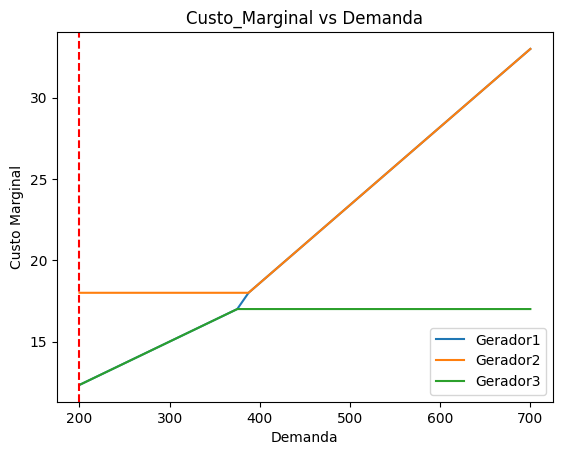

In [49]:
#entradas do problema
lista_geradores = [[0.04,7,0],[0.06,12,0],[0.02,9,0]]
restricoes =((50,500),(50,200),(0,200))
#restricoes = ((None,None),(None,None),(None,None))
lista_demanda = [200,700]
demanda = 350
plotar_grafico(lista_geradores,restricoes,lista_demanda)

In [38]:
#tomada de carga
tabelasss = tabela_demanda(lista_geradores,restricoes,lista_demanda)
print('[Demanda||CMO||Gerador||Limite Atingido]')
for x in range(len(tabelasss)):
    print('-----------------------------------------------------')
    print(tabelasss[x])



[Demanda||CMO||Gerador||Limite Atingido]
-----------------------------------------------------
[array([387.5]), 18.00000000000007, 'g1', array([50.])]
-----------------------------------------------------
[array([375.]), 16.999999999999986, 'g2', array([200.])]


In [50]:
#demanda fixa
print (minimizar(lista_geradores,restricoes,demanda))
print (custo_marginal(lista_geradores,restricoes,demanda))

[116.66558645  50.         183.33441355]
[16.33324691624924, 18.0, 16.333376541875378]


In [ ]:
'''i_demanda=[220,1200]
intervalo_demanda(geradores,restricoes,i_demanda)'''